Run full simulations in parallel
========================

In this section, we will learn how to:

- run full timeseries simulations in parallel (with multiprocessing) using the ``run_parallel_engine()`` function

Note: for a better understanding, it might help to read the previous tutorial section on running full timeseries simulations sequentially before going through the following

Imports and settings

In [1]:
# Import external libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

### Get timeseries inputs

In [2]:
def export_data(fp):
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df = export_data(filepath)
df_inputs = df.iloc[:48, :]

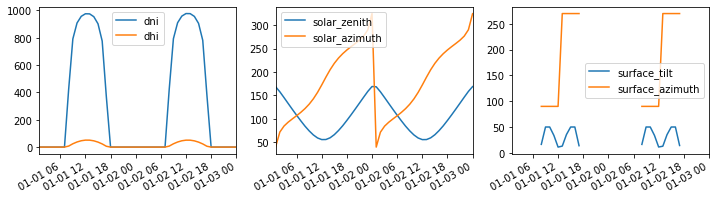

In [3]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [4]:
# Use a fixed albedo
albedo = 0.2

### Prepare PV array parameters

In [5]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
    'rho_front_pvrow': 0.01,  # pv row front surface reflectivity
    'rho_back_pvrow': 0.03    # pv row back surface reflectivity
}

### Run simulations in parallel with ``run_parallel_engine()``

Running full mode timeseries simulations in parallel is done using the ``run_parallel_engine()``.  
In the previous tutorial section on running timeseries simulations, we showed that a function needed to be passed in order to build a report out of the timeseries simulation.  
For the parallel mode, it will not be very different but we will need to pass a class (or an object) instead. The reason is that python multiprocessing uses pickling to run different processes, but python functions cannot be pickled, so a class or an object with the necessary methods needs to be passed instead in order to build a report.

An example of a report building class is provided in the ``report.py`` module of the pvfactors package.

In [6]:
# Choose the number of workers 
n_processes = 3

In [7]:
# import function to run simulations in parallel
from pvfactors.run import run_parallel_engine
# import the report building class for the simulation run
from pvfactors.report import ExampleReportBuilder

# run simulations in parallel mode
report = run_parallel_engine(ExampleReportBuilder, pvarray_parameters, df_inputs.index, 
                            df_inputs.dni, df_inputs.dhi, 
                            df_inputs.solar_zenith, df_inputs.solar_azimuth, 
                            df_inputs.surface_tilt, df_inputs.surface_azimuth, 
                            albedo, n_processes=n_processes)

# make a dataframe out of the report
df_report = pd.DataFrame(report, index=df_inputs.index)
df_report.iloc[6:11, :]

INFO:pvfactors.run:Parallel calculation elapsed time: 0.19038796424865723 sec


,qinc_front,qinc_back,iso_front,iso_back
2019-01-01 07:00:00-07:00,NaN,NaN,NaN,NaN
2019-01-01 08:00:00-07:00,117.632919,9.703464,5.070103,0.076232
2019-01-01 09:00:00-07:00,587.344197,4.906038,12.087407,2.150237
2019-01-01 10:00:00-07:00,685.115436,33.478098,17.516188,3.115967
2019-01-01 11:00:00-07:00,652.526254,52.534503,24.250780,1.697046


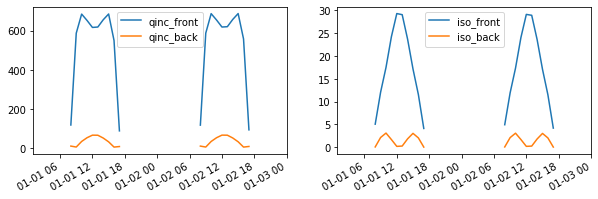

In [8]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))
df_report[['qinc_front', 'qinc_back']].plot(ax=ax[0])
df_report[['iso_front', 'iso_back']].plot(ax=ax[1])
plt.show()

The results above are consistent with running the simulations without parallel model (this is also tested in the package).

### Building a report for parallel mode

For parallel simulations, a **class** (or object) that builds the report needs to be specified, otherwise nothing will be returned by the simulation.  
Here is an example of a report building class that will return the total incident irradiance (``'qinc'``) on the back surface of the rightmost PV row. A good way to get started building the reporting class is to use the example provided in the ``report.py`` module of the pvfactors package.  
Another important action of the class is to merge the different reports resulting from the parallel simulations: **since the users decide how the reports are built, the users are also responsible for specifying how to merge the reports after a parallel run**.  

The static method that builds the reports needs to be named ``build(report, pvarray)``.  
And the static method that merges the reports needs to be named ``merge(reports)``.

In [9]:
class NewReportBuilder(object):
    """A class is required to build reports when running calculations with
    multiprocessing because of python constraints"""

    @staticmethod
    def build(pvarray):
        # Return back side qinc of rightmost PV row
        return {'total_inc_back': pvarray.ts_pvrows[-1].back.get_param_weighted('qinc').tolist()}

    @staticmethod
    def merge(reports):
        """Works for dictionary reports"""
        report = reports[0]
        # Merge other reports
        keys_report = list(reports[0].keys())
        for other_report in reports[1:]:
            for key in keys_report:
                report[key] += other_report[key]
        return report


In [10]:
# run simulations in parallel mode using the new reporting class
new_report = run_parallel_engine(NewReportBuilder, pvarray_parameters, df_inputs.index, 
                                df_inputs.dni, df_inputs.dhi, 
                                df_inputs.solar_zenith, df_inputs.solar_azimuth, 
                                df_inputs.surface_tilt, df_inputs.surface_azimuth, 
                                albedo, n_processes=n_processes)

# make a dataframe out of the report
df_new_report = pd.DataFrame(new_report, index=df_inputs.index)

INFO:pvfactors.run:Parallel calculation elapsed time: 0.19333314895629883 sec


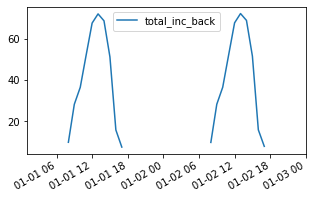

In [11]:
f, ax = plt.subplots(figsize=(5, 3))
df_new_report.plot(ax=ax)
plt.show()

The plot above shows that we're getting the same results we obtained in the previous tutorial section with the new report generating function.